### Imports

In [1]:
from pathlib import Path
import os
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
import pickle as pkl

from omegaconf import OmegaConf as omcon
from pytorch_lightning.loggers import WandbLogger


import torch
from torchvision import transforms as t
import pytorchvideo.transforms as ptvt

import sys
sys.path.append("..") # root of repo
sys.path.append("/nfs/home/rhotertj/Code/thesis/src")
import src.video_transforms as vt
from src.lit_models import LitModel, weighted_cross_entropy, unweighted_cross_entropy
from src.video_models import make_kinetics_mvit
from src.graph_models import GAT, PositionTransformer, GIN
from src.multimodal_models import MultiModalModel
from src.lit_data import LitMultiModalHblDataset, LitResampledHblDataset, collate_function_builder
from src.data.labels import LabelDecoder
from src.utils import get_proportions_df


/nfs/home/rhotertj/env/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/nfs/home/rhotertj/env/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### Load model and dataset

In [20]:
# dummy wandb
logger = WandbLogger(
        name="debug",
        offline=True,
        project="thesis_mvit"
    )

# ckpt_dir = Path("/nfs/home/rhotertj/Code/thesis/experiments/multimodal/train/copper-bush-8")
ckpt_dir = Path("/nfs/home/rhotertj/Code/thesis/experiments/mvit/train/silver-blaze-237")

ckpt_file = [f for f in os.listdir(ckpt_dir) if f.endswith(".ckpt")][0]
config = omcon.load(ckpt_dir / "config.yaml")

# remove pretrained model weights, they are overwritten anyways by lightning checkpoint
if config.model.name == "MultiModalModel":
    config.model.params.video_model_ckpt = ""
    config.model.params.graph_model_ckpt = ""

loss_func = eval(config.lit_model.loss_func)
label_decoder = LabelDecoder(config.num_classes)
config.data.params.batch_size = 1

lit_dataset = eval(config.data.name)(**config.data.params, label_mapping=label_decoder)
lit_dataset.setup("validate")
val_loader = lit_dataset.val_dataloader()
dataset = lit_dataset.data_val

model = eval(config.model.name)(**config.model.params,  num_classes=config.num_classes, batch_size=config.data.params.batch_size)

lit_model = LitModel.load_from_checkpoint(
    ckpt_dir / ckpt_file,
    optimizer=None,
    scheduler=None,
    loss_func=loss_func,
    model=model,
    label_mapping=label_decoder
)

if torch.cuda.is_available():
    print("GPU!")
    lit_model.cuda()

base_path = Path(".") / "analysis" / ckpt_dir.name
if not os.path.exists(base_path):
    os.makedirs(base_path)


/nfs/home/rhotertj/env/miniconda3/envs/thesis/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Read /nfs/home/rhotertj/datasets/hbl/meta30_valid.csv


### Run prediction on validation data and save results

In [21]:
val_res_name = base_path / "val_results.pkl"
if not os.path.exists(val_res_name):

    val_results = [] # list of dicts with all info but frames, we can load them later via frame number!

    for instance in tqdm(val_loader):
        instance["frames"] = instance["frames"].to("cuda:0")
        instance["positions"] = instance["positions"].to("cuda:0")
        pred = lit_model.forward(instance).detach().cpu()
        loss = loss_func(pred, instance["label"], instance["label_offset"])
        res = {
            "query_idx" : instance["query_idx"].item(),
            "label" : instance["label"].item(),
            "label_offset" : instance["label_offset"].item(),
            "prediction" : pred.detach().cpu().numpy().argmax(-1),
            "loss" : loss.item()
        }
        val_results.append(res)

    with open(val_res_name, "wb+") as f:
        pkl.dump(val_results, f)

else:
    with open(val_res_name, "rb") as f:
        val_results = pkl.load(f)

### Distribution over offsets

In [22]:
df = pd.DataFrame(val_results)
df["correct"] = False
df.loc[df["label"] == df["prediction"], "correct"] = True
df_nobg = df[df["label"] != 0]

<Axes: xlabel='label_offset', ylabel='count'>

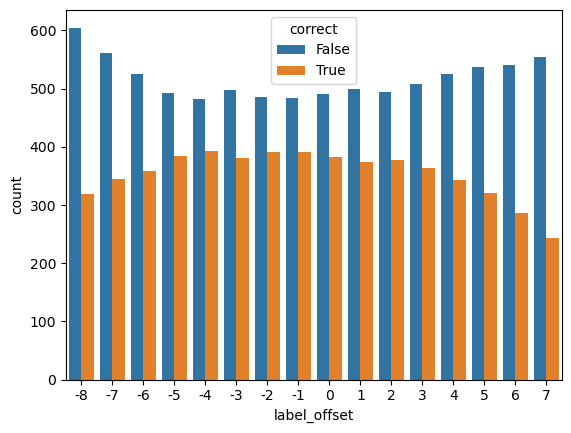

In [23]:
sns.countplot(data=df_nobg, x="label_offset", hue="correct")

### Confusion per class

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


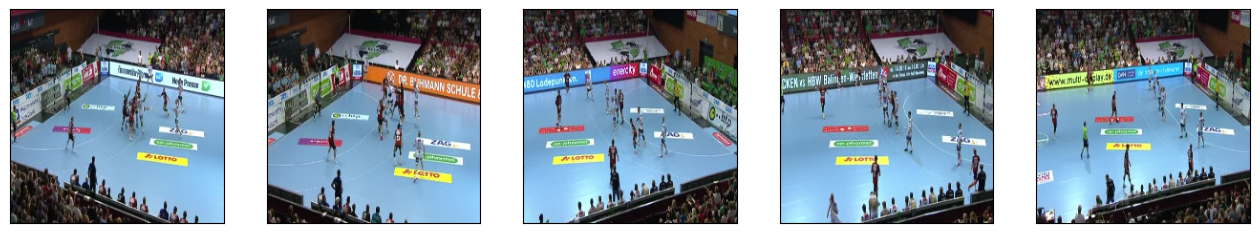

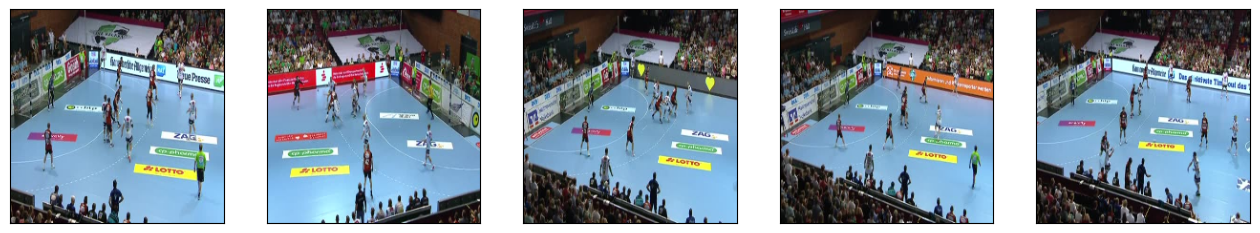

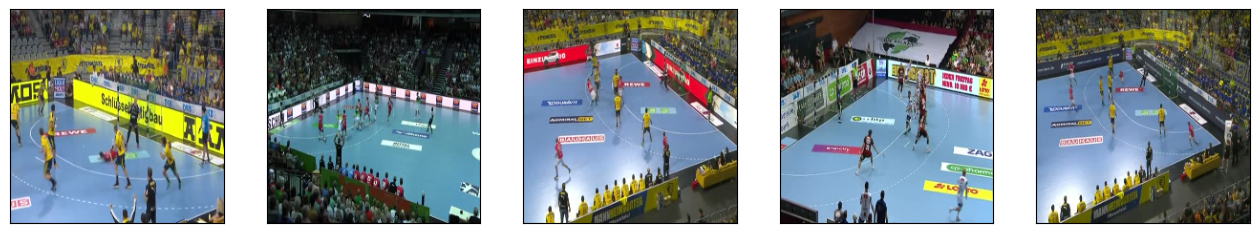

In [24]:
def animate_samples(dataset, df, n, axis):
    sample_frames = []
    for i, sample in df.sample(n).iterrows():
        idx = sample["query_idx"]
        frames = dataset[idx]["frames"].numpy() # cthw
        sample_frames.append(frames)
    # list of 16 entries, each a list of n frames
    sample_frames = np.stack(sample_frames) # ncthw
    sample_frames = np.einsum("ncthw->nthwc", sample_frames)

    images = []
    for t in range(sample_frames.shape[1]):
        images_at_timestep = []
        for i in range(sample_frames.shape[0]):
            im = axis[i].imshow(sample_frames[i, t])
            axis[i].tick_params(
                top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=False,
                labelbottom=False
            )
            images_at_timestep.append(im)
        images.append(images_at_timestep)

    ani = animation.ArtistAnimation(fig, images, interval=50, blit=True, repeat_delay=1000)
    return ani

for c in label_decoder.get_classnames():
    label_int = label_decoder.get_classnames().index(c)
    n = 5
    fig, axis = plt.subplots(1, n, figsize=(16,8))

    tp = df[(df["label"] == label_int) & (df["prediction"] == label_int)]
    fp = df[(df["label"] != label_int) & (df["prediction"] == label_int)]
    fn = df[(df["label"] == label_int) & (df["prediction"] != label_int)]


    animate_samples(dataset, tp, 5, axis).save(base_path / f"{c}_tp.gif", fps=10)
    animate_samples(dataset, fp, 5, axis).save(base_path / f"{c}_fp.gif", fps=10)
    animate_samples(dataset, fn, 5, axis).save(base_path / f"{c}_fn.gif", fps=10)


### Top-k loss predictions

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


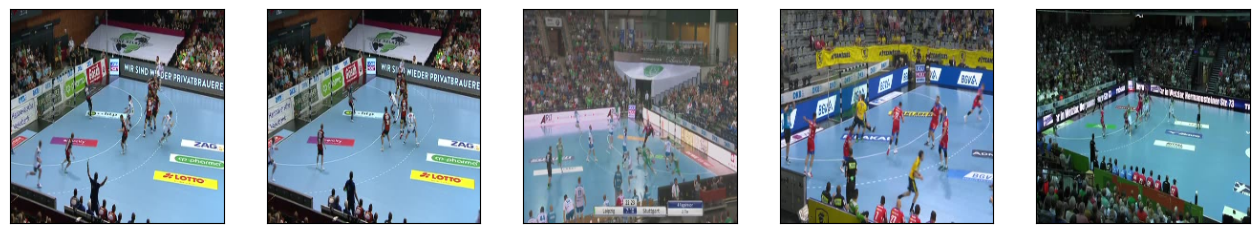

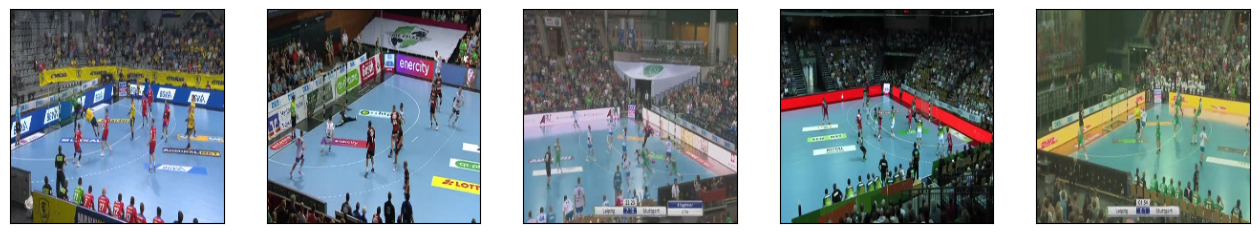

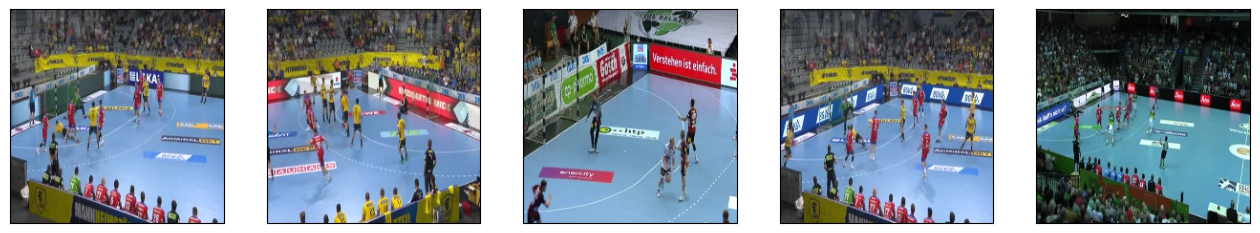

In [25]:
for c in label_decoder.get_classnames():
    label_int = label_decoder.get_classnames().index(c)
    n = 5
    fig, axis = plt.subplots(1, n, figsize=(16,8))
    c_df = df[df["label"] == label_int]
    topk = c_df.sort_values(by="loss", ascending=True).head(n)
    worstk = c_df.sort_values(by="loss", ascending=False).head(n)
    

    animate_samples(dataset, tp, 5, axis).save(base_path / f"{c}_topk.gif", fps=10)
    animate_samples(dataset, tp, 5, axis).save(base_path / f"{c}_worstk.gif", fps=10)
